# First, load the image and resize it

The size of the resized image will affect downstream parameters like edge detection and gaussian blurring

In [352]:
# Prestep where the user chooses they have an On/Go test

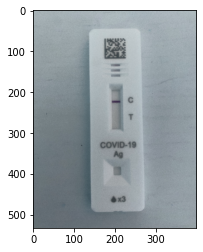

In [353]:
import sys
import math
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
maxwidth, maxheight = 400, 600

# Loads an image
img = cv.imread('data/examples/on_go.png')
f1 = maxwidth / img.shape[1]
f2 = maxheight / img.shape[0]
f = min(f1, f2)  # resizing factor
dim = (int(img.shape[1] * f), int(img.shape[0] * f))
resized = cv.resize(img, dim)

plt.imshow(resized)
plt.show()

# Alignment Frames

For each image type we need to understand the alignment frame that the camera forces the user to collect against.

In this case, we are assuming an alignment frame of `[(130, 40), (270, 40), (270,490), (130, 490)]` relative to the resized image. This should be expressed as a percentage of the image to be size invariant.

The following cell is not part of the overall pipeline. This is just to show what that means.

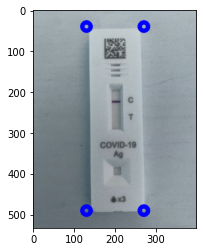

In [354]:
alignment = resized.copy()
circles = [(130, 40), (270, 40), (270,490), (130, 490)]
for coord in circles:
    cv.circle(
        alignment,
        coord,
        radius=10,
        color=(0, 0, 255),
        thickness=10,
    )
plt.imshow(alignment)
plt.show()

In [355]:
def blur_within(image, p1, p2):
    # First crop the region out of the original image
    x1, y1 = p1[0], p1[1]
    w, h = p2[0] - p1[0], p2[1] - p1[1]
    ROI = image[y1:y1+h, x1:x1+w]
    blur = cv.GaussianBlur(ROI, (51,51), 0)
    image[y1:y1+h, x1:x1+w] = blur
    return image

def add_coordinates(pos, diff):
    return (pos[0] + diff[0], pos[1] + diff[1])

def blur_without(image, p1, p2):
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
    height, width = image.shape[0], image.shape[1]
    image = blur_within(image, (0, 0), (width, y1))
    image = blur_within(image, (0, 0), (x1, height))
    image = blur_within(image, (0, y2), (width, height))
    image = blur_within(image, (x2, 0), (width, height))
    return image

# Gaussian Blurring

The next goal is to **blur within** and **blur without**. This will reduce edge noises around the main device. Once we can localize the device, the problem is effectively solved.

Blur within means to blur everything within 10 pixels of the box.

Blur without means to blur everything 10 pixels away from the box.

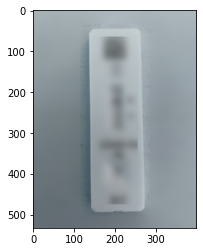

In [356]:
BLURRING_SENSIVITY = 15

blurred = blur_within(
    resized.copy(),
    add_coordinates((130, 50), (BLURRING_SENSIVITY, BLURRING_SENSIVITY)),
    add_coordinates((270,490), (-BLURRING_SENSIVITY, -BLURRING_SENSIVITY)),
)

blurred = blur_without(
    blurred,
    add_coordinates((130, 50), (-BLURRING_SENSIVITY, -BLURRING_SENSIVITY)),
    add_coordinates((270,490), (BLURRING_SENSIVITY, BLURRING_SENSIVITY)),
)

plt.imshow(blurred)
plt.show()

# Edge Detection

Now we are ready to run an edge detector over this. Edge detectors convolve a filter over an image that meaures changes in pixel intensity. This *heavily* depends on the size of the image to set the filter width. (Larger images have larger border which need larger filters to detect)

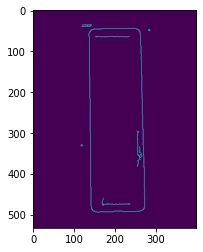

In [357]:
KERNEL_SIZE = 5

canny = cv.GaussianBlur(blurred.copy(), (KERNEL_SIZE, KERNEL_SIZE), 0)
canny = cv.Canny(canny, 3, 55, None, 3)
plt.imshow(canny)
plt.show()

# Line Detection

The last thing we need to do is to perform a hough transform + thresholding to transform from coordinate space to hough space.

Effectively this just means: For each point, solving `a, b` where `x, y` are known for `y = ax + b`.

[See a demo of hough transforms here](https://www.aber.ac.uk/~dcswww/Dept/Teaching/CourseNotes/current/CS34110/hough.html).

In [344]:
HOUGH_THRESHOLD = 40

lines = cv.HoughLines(canny, 1, np.pi / 40, HOUGH_THRESHOLD, None, 0, 0)
print("Detected {} lines".format(len(lines)))
def is_horizontal(line):
    return line[0][1] > 1.5 and line[0][1] < 1.63
def is_vertical(line):
    return (line[0][1] > -.07 and line[0][1] < 0.07) or (line[0][1] > math.pi-.07 and line[0][] < math.pi + 0.07)

horizontal_lines = []
vertical_lines = []
for line in lines:
    rho = line[0][0]
    theta = line[0][1]

    if is_horizontal(line):
        horizontal_lines.append(line)
    if is_vertical(line):
        vertical_lines.append(line)

print("Filtered down to {} lines".format(len(horizontal_lines + vertical_lines)))

Detected 24 lines
255.0 ,  0.0
132.0 ,  0.0
130.0 ,  0.0
284.0 ,  0.0
264.0 ,  0.0
492.0 ,  1.5707964
34.0 ,  1.5707964
268.0 ,  0.0
65.0 ,  1.5707964
-247.0 ,  3.063053
474.0 ,  1.5707964
-252.0 ,  3.063053
151.0 ,  0.07853982
-242.0 ,  3.063053
-231.0 ,  3.063053
-235.0 ,  3.063053
-238.0 ,  3.063053
295.0 ,  0.07853982
-198.0 ,  2.984513
-245.0 ,  3.063053
-227.0 ,  3.063053
-233.0 ,  3.063053
115.0 ,  0.0
298.0 ,  0.07853982
Filtered down to 11 lines


492.0 ,  1.5707964
34.0 ,  1.5707964
65.0 ,  1.5707964
474.0 ,  1.5707964
255.0 ,  0.0
132.0 ,  0.0
130.0 ,  0.0
284.0 ,  0.0
264.0 ,  0.0
268.0 ,  0.0
115.0 ,  0.0


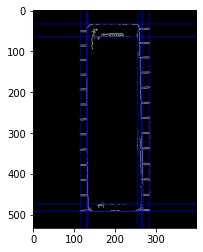

In [351]:
def create_points_on_line(line):
    rho = line[0][0]
    theta = line[0][1]
    print(rho, ", ", theta)
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    return (pt2, pt1)

lines_img = cv.cvtColor(canny, cv.COLOR_GRAY2BGR)

horizontal_lines_defined_by_two_points = [create_points_on_line(line) for line in horizontal_lines]
vertical_lines_defined_by_two_points = [create_points_on_line(line) for line in vertical_lines]
for (pt2, pt1) in horizontal_lines_defined_by_two_points:
    cv.line(lines_img, pt1, pt2, (0, 0, 255), 1, cv.LINE_AA)
for (pt2, pt1) in vertical_lines_defined_by_two_points:
    cv.line(lines_img, pt1, pt2, (0, 0, 255), 1, cv.LINE_AA)

plt.imshow(lines_img)
plt.show()

In [345]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

array([[-227.      ,    3.063053]], dtype=float32)

# Find vertical and horizontal lines



# TODO: Extract Largest Box
Detect boxes


# TODO: Perspective Correction
Detect boxes


# TODO: Region Extraction
Detect boxes


# TODO: Result Prediction
Detect boxes
